In [70]:
import os
import pandas as pd
import numpy as np
import sklearn
import math
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [71]:
os.chdir('/Users/siu/Downloads')
df = pd.read_csv('cdd_pm_adme.csv')

In [72]:
df.head()

,smiles,name,Synonyms,Projects,"Caco-2 permeability assay: Mean Papp, A to B (10-6 cm/s)",permeability,Caco-2 permeability assay: Site,Caco-2 permeability assay: Papp,herg,ms,solubility_water,solubility_pbs,ms_mlm
0,CN1C(=O)N(CC2=CC=C(F)C=C2)C(=O)C2=CN=C(N=C12)C...,STE-2510204,L559-0328,MP00307,9.75,21.067404,Wuxi,High,0.364876,0.655032,-5.039802,0.863041,0.542983
1,NC(=O)C1=CC(Cl)=C(OCC2=CN=C3CN(CCC3=C2)C2=NC=N...,STD-0003048,STV-0003353,MP00307,0.3,6.777841,Wuxi,Low,0.474817,0.643027,-4.935338,0.974736,0.605919
2,ClC1=CC2=C(NC(=N2)C(=O)N2CCC(=CC2)C2=CNC3=C2C=...,STD-0003047,STV-0004465,MP00204,2.1,7.922799,Wuxi,Moderate,0.446075,0.687454,-4.907382,0.945537,0.785888
3,O=C(N1CCC(=CC1)C1=CNC2=C1C=CC=N2)C1=NC2=C(N1)C...,STD-0003046,STV-0004903,MP00204,11.5,8.099379,Wuxi,High,0.406495,0.512975,-4.531440,0.770275,0.822740
4,COC1=CC2=C(C=C1)N=C(N2)C(=O)N1CCC(=CC1)C1=CNC2...,STD-0003045,STV-0004904,MP00204,9.2,6.864312,Wuxi,High,0.411878,0.803020,-4.822271,0.905990,0.784711


## 데이터 프렙

In [69]:
# (X) 예측값은 양수가 좋은(good cpd) 의미로 변환해야 함. 1에 가까울수록 bad라면 음수를 취한다.
# df['solubility_pbs_1'] = -(df['solubility_pbs'])

# log 변환이 필요한 경우
# df['log_per'] = df['permeability'].apply(lambda x: math.log10(x))

In [73]:
# (Y) 실험값에서 부등호 제거하고 필요한 경우 로그
y_col = 'Caco-2 permeability assay: Mean Papp, A to B (10-6 cm/s)'
ycutoff = 0.5

df['EXP_Value'] = df[y_col].apply(lambda x: float(x.strip(">""<""=")))
# df['EXP_Value'] = df['EXP_Value'].apply(lambda x: math.log10(x))   # 로그 변환이 필요한 경우
df['EXP_Class'] = df['EXP_Value'].apply(lambda x : 1 if x < ycutoff else 0)

print('[(실험값의) 최소값, 최대값]', min(df['EXP_Value']), max(df['EXP_Value']))

[(실험값의) 최소값, 최대값] 0.01 21.6


In [79]:
# (Y) 공통 파라미터 (아래 함수에 파라미터로 필요함)
dataframe = df
y_value_col = 'EXP_Value'
y_class_col = 'EXP_Class'
y_value_range = [-1,10]
ycutoff = ycutoff

### 함수

In [80]:
def draw_CM(df, y_value_col, y_class_col, model_name, model_col, ycutoff, xcutoff, y_value_range, x_value_range):
    
    # X 값 0,1로 분류한 후 confusion matrix 생성
    df[model_col+'_Class'] = df[model_col].apply(lambda x : 1 if x < xcutoff else 0)

    for x,y,i in zip(df[model_col+'_Class'], df[y_class_col], df.index):
        if y==1 and x==1: df.loc[i, model_col+'_Class_CM'] = 'True Bad'
        elif y==1 and x==0: df.loc[i, model_col+'_Class_CM'] = 'False Good'
        elif y==0 and x==0: df.loc[i, model_col+'_Class_CM'] = 'True Good'
        elif y==0 and x==1: df.loc[i, model_col+'_Class_CM'] = 'False Bad'

    cm = confusion_matrix(df[y_class_col], df[model_col+'_Class']) 
    df_cm = pd.DataFrame(cm, index=['good', 'bad'], columns=['good', 'bad'])
    df_cm = df_cm[['bad', 'good']]   # X 축 컬럼 순서를 한 번 바꿔줌 (P,N -> N,P)
    
    FP = df_cm.loc['good','bad']   # good_exp, bad_pred (FP)
    TN = df_cm.loc['good','good']   # good_exp, good_pred (TN)
    TP = df_cm.loc['bad','bad']   # bad_exp, bad_pred (TP)
    FN = df_cm.loc['bad','good']   #  bad_exp, good_pred (FN)
    
    # precision, recall
    precision = round(TP/(TP+FP),2)
    recall = round(TP/(TP+FN),2)
    accuray = round((TP+TN)/(TP+TN+FP+FN),2)
    f1 = round(2*((precision*recall)/(precision+recall)),2)
    
    # 크기 설정
    fig, ax = plt.subplots(figsize=(12,10))
    
    # 선 그리기
    plt.axhline(y = ycutoff, color = 'black', linestyle = '-', linewidth=2)
    plt.axvline(x= xcutoff, color='black', linestyle='-', linewidth=2)

    # 축 범위
    plt.axis([x_value_range[0], x_value_range[1], y_value_range[0], y_value_range[1]])

    # 컬러링
    ax.axvspan(x_value_range[0], xcutoff, facecolor='red', alpha=0.2)
        
    # 사분면 라벨
    x_pos_L = np.percentile(np.array(x_value_range), q=[25,75])[0]
    x_pos_R = np.percentile(np.array(x_value_range), q=[25,75])[1]
    y_pos_T = np.percentile(np.array(y_value_range), q=[25,75])[1]
    y_pos_B = np.percentile(np.array(y_value_range), q=[25,75])[0]
    
    ax.text(x_pos_L, y_pos_T, 
            f"BAD\n(False)\n[{FP}]",   
            color="red",
            size="20",
            fontweight='semibold',
            horizontalalignment='center',
            verticalalignment='top')
    ax.text(x_pos_R, y_pos_T,
            f"GOOD\n[{TN}]",   
            color="green",size="20",
            fontweight='semibold',
            horizontalalignment='center',
            verticalalignment='top')
    ax.text(x_pos_L, y_pos_B,
            f"BAD\n[{TP}]",   
            color="green",size="20",
            fontweight='semibold',
            horizontalalignment='center',
            verticalalignment='top')
    ax.text(x_pos_R, y_pos_B,
            f"GOOD\n(False)\n[{FN}]",   
            color="orange",size="20",
            fontweight='semibold',
            horizontalalignment='center',
            verticalalignment='top')

    # 타이틀 및 라벨 크기
    plt.suptitle(f'{model_name}', fontsize=25)
    plt.title(f"XCutoff: {xcutoff} | Precision: {precision} | Recall: {recall} | Accuray: {accuray}\n", fontsize=15)
    
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel("Prediction (Log)", fontsize=20)
    plt.ylabel("Experiment (Log)", fontsize=20)
    
    colors = {1:'red', 0:'green'}
    ax.scatter(df[model_col], df[y_value_col], c=df[y_class_col].map(colors), alpha=0.75, s=100)
    
    plt.savefig(f'{model_name}.png')
    
    return df_cm

## 각 예측값마다 그래프 그리기

/var/folders/v3/bs3zqkg56xz3bkbg5cnxwm9m0000gn/T/ipykernel_30466/3195612692.py:22: RuntimeWarning: invalid value encountered in long_scalars
  precision = round(TP/(TP+FP),2)


,bad,good
good,0,41
bad,0,11


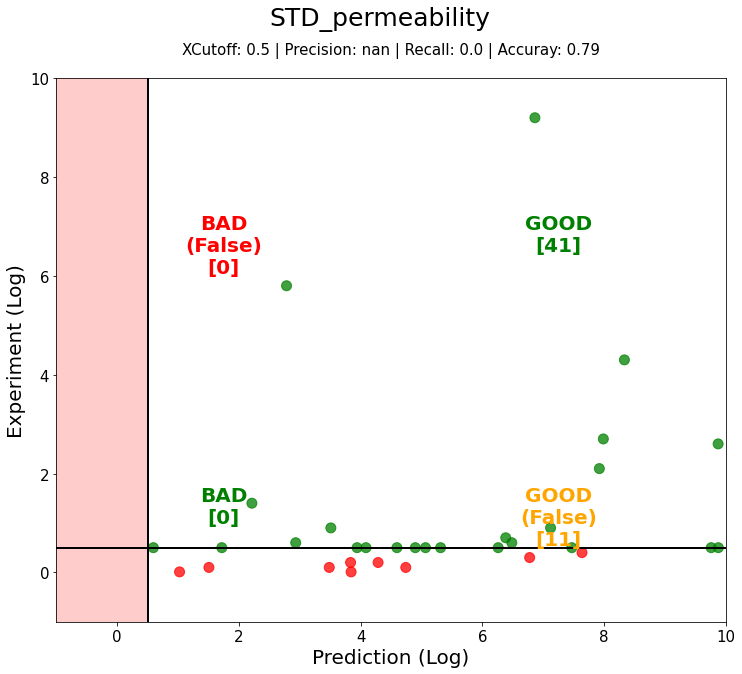

In [81]:
model_name = 'STD_permeability'
model_col_name = 'permeability'
xcutoff = 0.5
x_value_range = [-1,10]

draw_CM(dataframe, y_value_col, y_class_col, model_name, model_col_name, ycutoff, xcutoff, y_value_range, x_value_range)

,bad,good
good,2,4
bad,40,21


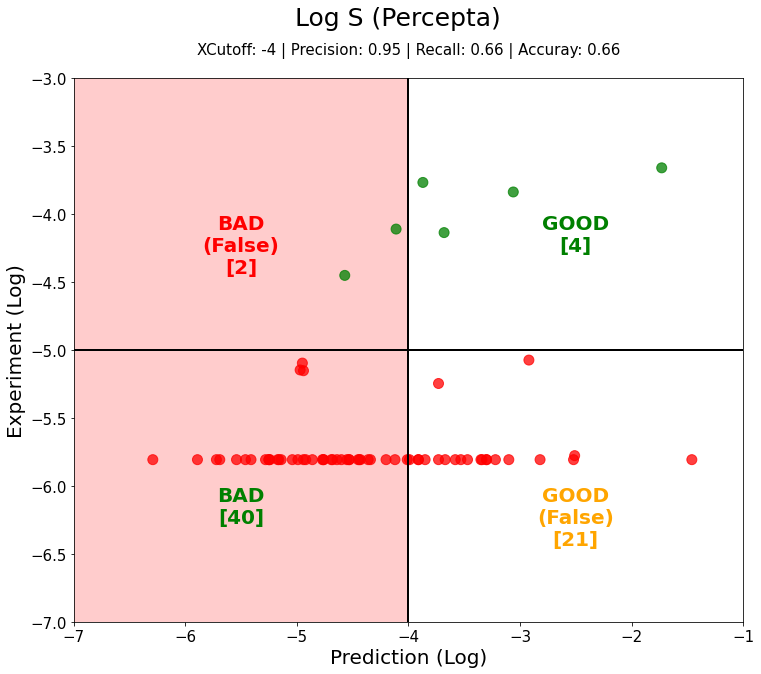

In [342]:
model_name = 'Log S (Percepta)'
model_col_name = 'LogS (pH = 7.40)'
xcutoff = -4
x_value_range = [-7,-1]

draw_CM(dataframe, y_value_col, y_class_col, model_name, model_col_name, ycutoff, xcutoff, y_value_range, x_value_range)

,bad,good
good,5,1
bad,60,1


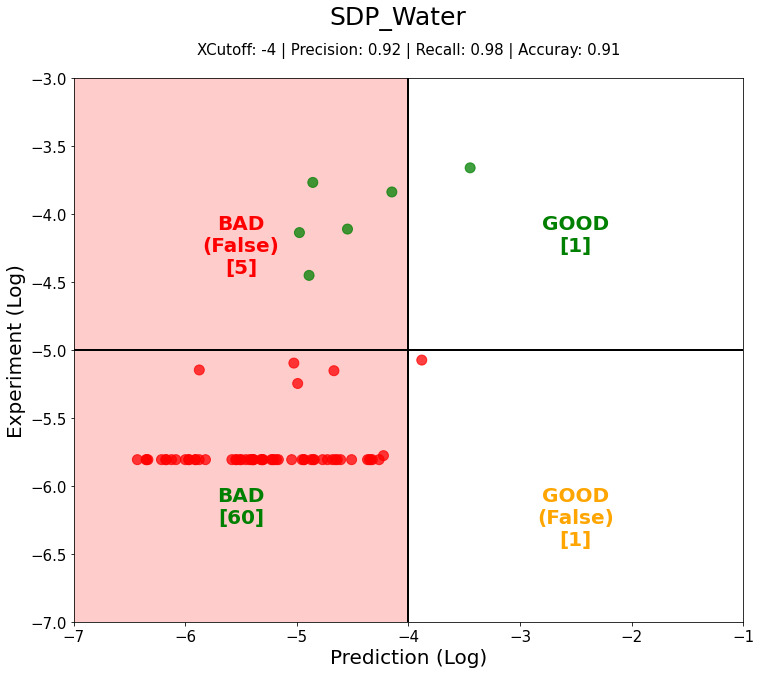

In [343]:
model_name = 'SDP_Water'
model_col_name = 'solubility_water'
xcutoff = -4
x_value_range = [-7,-1]

draw_CM(dataframe, y_value_col, y_class_col, model_name, model_col_name, ycutoff, xcutoff, y_value_range, x_value_range)

,bad,good
good,4,2
bad,60,1


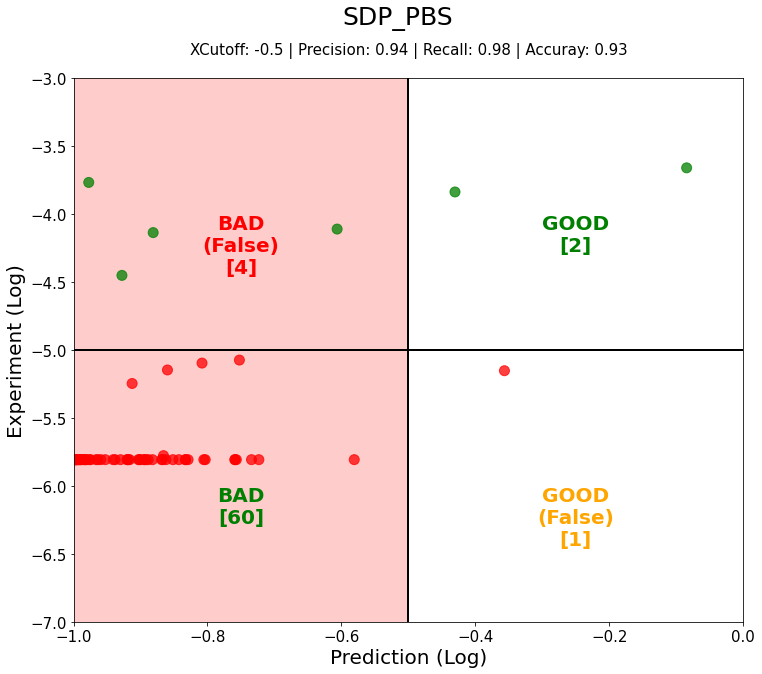

In [344]:
model_name = 'SDP_PBS'
model_col_name = 'solubility_pbs_1'
xcutoff = -0.5
x_value_range = [-1,0]

draw_CM(dataframe, y_value_col, y_class_col, model_name, model_col_name, ycutoff, xcutoff, y_value_range, x_value_range)

In [345]:
df.to_csv('eval_sol_models_ipynb.csv')

## 테스트한 코드

In [ ]:
model_name = 'Log S (CDD)'
model_col = 'log S'
cutoff = -4
cutoff_range = [-7, 0]

In [ ]:
df[model_col+'_Class'] = df[model_col].apply(lambda x : 1 if x < cutoff else 0)

for x,y,i in zip(df[model_col+'_Class'], df['Solubility_Y_Class'], df.index):
    if y==1 and x==1: df.loc[i, model_col+'_Class_CM'] = 'True Bad'
    elif y==1 and x==0: df.loc[i, model_col+'_Class_CM'] = 'False Good'
    elif y==0 and x==0: df.loc[i, model_col+'_Class_CM'] = 'True Good'
    elif y==0 and x==1: df.loc[i, model_col+'_Class_CM'] = 'False Bad'

cm = confusion_matrix(df['Solubility_Y_Class'], df[model_col+'_Class']) 
df_cm = pd.DataFrame(cm, index=['good', 'bad'], columns=['good', 'bad'])
df_cm = df_cm[['bad', 'good']]

In [ ]:
# 선 그리기
fig, ax = plt.subplots(figsize=(15,10))
plt.axhline(y = crit, color = 'black', linestyle = '-', linewidth=3)
plt.axvline(x= cutoff, color='black', linestyle='-', linewidth=3)

# 축 범위
plt.axis([cutoff_range[0], cutoff_range[1], -7, 0])

# 컬러링
ax.axvspan(cutoff_range[0], cutoff, facecolor='red', alpha=0.2)

# 사분면 라벨
ax.text(-5.5,-2,f"WRONG\nFILTERED\n[{df_cm.loc['good','bad']}]",color="red",size="20", fontweight='semibold', horizontalalignment='center', verticalalignment='top')
ax.text(-2,-2,f"KEPT\n[{df_cm.loc['good','good']}]",color="green",size="20", fontweight='semibold', horizontalalignment='center', verticalalignment='top')
ax.text(-5.5,-6,f"FILTERED\n[{df_cm.loc['bad','bad']}]",color="green",size="20", fontweight='semibold', horizontalalignment='center', verticalalignment='top')
ax.text(-2,-6,f"WRONG\nKEPT\n[{df_cm.loc['bad','good']}]",color="orange",size="20", fontweight='semibold', horizontalalignment='center', verticalalignment='top')

ax.text(-7+0.2,-5+0.2,f"Real Goods [{sum(df_cm.loc['good',:])}]",color="black",size="10", fontweight='semibold', horizontalalignment='left', verticalalignment='center')
ax.text(-7+0.2,-5-0.2,f"Real Bads [{sum(df_cm.loc['bad',:])}]",color="black",size="10", fontweight='semibold', horizontalalignment='left', verticalalignment='center')

# 타이틀 및 라벨 크기
plt.title(f'LogS (CDD) | Cutoff : {cutoff}\n', fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Prediction (Log)", fontsize=20)
plt.ylabel("Experiment (Log)", fontsize=20)
plt.scatter(df['log S'], df['Solubility_Y'])